In [18]:
import numpy as np
import math
import argparse
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from enum import Enum
import random
from random import randint
from networkx.algorithms.community import k_clique_communities 
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import asyn_lpa_communities
from networkx.algorithms.community.quality import coverage
from networkx.algorithms.community.quality import performance
from sklearn.utils import shuffle

In [19]:
start_time = datetime.now()

H = nx.Graph()
candidate =['Donald Trump','Hillary Clinton']
edge_list =pd.read_csv('politician_edges.csv',delimiter =',')

In [20]:
c=0
for i in range(len(edge_list['node_1'])):
    if edge_list['node_1'][i] == edge_list['node_2'][i]:
        continue
    else:
        H.add_edge(edge_list['node_1'][i],edge_list['node_2'][i])

In [21]:
c=0
node_list =pd.read_csv('Sentiment.csv',delimiter =',',index_col=False)
node_list =shuffle(node_list)

print node_list.isnull().sum()
node_list.fillna(method='bfill')

for i,val in H.nodes(data=True):
    H.node[i]['id'] =node_list['id'][c]
    if node_list['candidate'][c] =='No candidate mentioned':
        H.node[i]['candidate'] =random.choice(candidate)
    else:
        H.node[i]['candidate'] =node_list['candidate'][c]
    H.node[i]['sentiment'] =node_list['sentiment'][c]
    H.node[i]['senticonfidence'] =node_list['sentiment_confidence'][c]
    H.node[i]['tweetcreated'] =node_list['tweet_created'][c]
    H.node[i]['tweet'] =node_list['tweet_id'][c]
    H.node[i]['name'] =node_list['name'][c]
    c=c+1
nx.write_gml(H,'sentiment_graph.gml')

id                               0
candidate                       96
candidate_confidence             0
relevant_yn                      0
relevant_yn_confidence           0
sentiment                        0
sentiment_confidence             0
subject_matter                 326
subject_matter_confidence        0
candidate_gold               13843
name                             0
relevant_yn_gold             13839
retweet_count                    0
sentiment_gold               13856
subject_matter_gold          13853
text                             0
tweet_coord                  13850
tweet_created                    0
tweet_id                         0
tweet_location                3912
user_timezone                 4403
dtype: int64


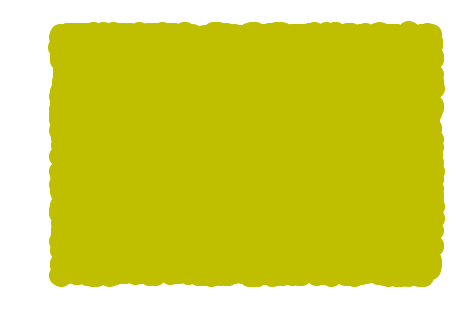

In [ ]:
pos=nx.random_layout(H)
plt.figure()
nx.draw(H,node_size=400,pos=pos,node_color='y', with_labels=False)
plt.show()

In [ ]:
k_core =min(H.degree(nx.k_core(H).nodes()),key=lambda item:item[1])
print 'k-core of graph:',k_core[1]

print 'number of nodes:', len(H.nodes()), 'number of edges:', len(H.edges())
start_time = datetime.now()
prob_dict ={}
prob1_dict ={}
c =0
for item, dict1 in H.nodes(data=True):
      for key, value in dict1.items():
          if (key, value) in prob_dict.keys():
              prob_dict[(key,value)] =prob_dict[(key, value)] +1
          else:
              prob_dict[(key, value)] =1


for key, value in prob_dict.items():
    if (float(float(value)/float(len(H.nodes()))) * 100) >= 10.0:
        prob1_dict[key] =float(float(value)/float(len(H.nodes()))) * 100

prob_dict =sorted([{v:k} for (k,v) in prob1_dict.items()], reverse=True)
print 'prob-dict:', prob_dict

k-core of graph: 38
number of nodes: 5908 number of edges: 41706


In [ ]:
class_dict ={}
i =0 
for item in prob_dict:
    for key, value in item.items():
        class_dict[value] = i
    i =i+1
print 'class-dict:', class_dict

atr_index ={}
atr_list =[]
for item, dict1 in H.nodes(data=True):
    for key, value in dict1.items():
        if (key, value) in class_dict.keys():
            atr_list.append(class_dict[(key, value)])
    atr_index[item] =atr_list
    atr_list =[]

In [ ]:
node_clss ={}
node_clss2 ={}
atr_index2 ={}
prob_matrix = np.zeros(shape=(len(class_dict),len(class_dict)))
prob_matrix1 = np.zeros(shape=(len(class_dict),len(class_dict)))
for edge in H.edges():
    list1 =[]
    list2 =[]
    list3 =[]
    list1 = atr_index[edge[0]]
    list2 = atr_index[edge[1]]
    list3 =set(list1).intersection(set(list2))

    if len(list3) >0:  
        for it1 in list3:
            for it2 in list3:        
                prob_matrix[int(it1), int(it2)] = prob_matrix[int(it1), int(it2)] +1
            
    for it in list3:       
        if it in node_clss.keys():
            node_clss[it] =node_clss[it] +1
        else:
            node_clss[it] =1

In [ ]:
for key, val in node_clss.items():
    val1 =float(float(val)/float(len(H.edges()))) *100
    if val1 >= 5.0:
        node_clss2[key] =val1               
        
print 'attr edge count:', node_clss2

In [ ]:
Attr_Index1 ={}
attr_list =np.zeros(len(class_dict))
for item, dict1 in H.nodes(data=True):
    deg = H.degree(item)
    attr_list =[]
    for key, val in dict1.items():
        if (key, val) in class_dict.keys():
            if class_dict[(key, val)] in node_clss2.keys():
           #     print 'node attr clss:', class_dict[(key, val)], node_clss2[class_dict[(key, val)]]
                attr_list.append(class_dict[(key, val)])
   # print 'attr list:', item, attr_list
    Attr_Index1[item] =attr_list

In [ ]:
cl=0   
attr_index_class ={}
attr_class_dict={}
attr_list1 =[]
attr_list2 =[]
clss_list =[]
clss =[]
l1 =0
l2 =0
count =0
for node, sig in H.nodes(data=True):
    list1 = Attr_Index1[node]
    deg = H.degree(node)
    clss_list=[]
    l2 =0
    if deg >= k_core[1] and len(list1) >0:
        if not attr_index_class:
            if l2 ==0:
                cl = cl+1
                count =count+1
                attr_index_class[cl] ={'node':node, 'attr': list1, 'count':count}
                attr_class_dict[cl] =list1
                clss_list.append(cl)
                sig['class'] = clss_list
            l2 =l2+1
        else:
            for key, dict1 in attr_index_class.items():
                list2 = dict1['attr']
                jcd = float(float(len(set(list1).intersection(set(list2))))/float(len(set(list1).union(set(list2))))) * 100
                union = list(set(list1).union(set(list2)))
                diff = set(list1).difference(set(list2))
                common = set(list1).intersection(set(list2))
                if jcd >= 70.0:
                    l1=l1+1
                    if len(diff) ==0:
                        dict1['count']=dict1['count'] +1
                    else:
                        dict1['attr'] = union
                        dict1['count']=dict1['count'] +1
                        attr_class_dict[key] =union
                    if 'class' not in sig.keys():
                        clss_list.append(key)
                        sig['class'] = clss_list
                    else:
                        if key in sig['class']:
                            continue
                        else:
                            clss_list = sig['class']
                            clss_list.append(key)
                            sig['class']= clss_list
                    break
                else:
                    if len(common) >0:
                        if len(list1) < len(list2):
                            if set(list1).issubset(set(list2)):
                                c =c+1
                                attr_index_class[key]['attr'] =list(set(list1).union(set(list2)))
                                attr_index_class[key]['count']=attr_index_class[key]['count'] +1
                                attr_class_dict[key] =list(set(list1).union(set(list2)))
                                if 'class' not in sig.keys():
                                    clss_list.append(key)
                                    sig['class'] = clss_list
                                else:
                                    if key in sig['class']:
                                        continue
                                    else:
                                        clss_list = sig['class']
                                    clss_list.append(key)
                                    sig['class']= clss_list
                                break
                        else:                     
                            for it in list1:
                                if it in list2:
                                    c =c+1
                                    attr_index_class[key]['attr'] =list(set(diff).union(set(list2)))
                                    attr_index_class[key]['count']=attr_index_class[key]['count'] +1
                                    attr_class_dict[key] =list(set(diff).union(set(list2)))
                                    if 'class' not in sig.keys():
                                        clss_list.append(key)
                                        sig['class'] = clss_list
                                    else:
                                        if key in sig['class']:
                                            continue
                                        else:
                                            clss_list = sig['class']
                                            clss_list.append(key)
                                            sig['class']= clss_list
                                    break
                                    
            if l1 ==0 and c==0 and jcd < 70.0:    
                cl =cl+1
                count =count+1
                attr_index_class[cl] ={'node':node, 'attr': list1, 'count':count}
                attr_class_dict[cl] =list1
                        
                if 'class' not in sig.keys():
                        clss_list.append(cl)
                        sig['class'] = clss_list
                else:
                    if cl in sig['class']:
                        continue
                    else:
                        clss_list = sig['class']
                        clss_list.append(cl)
                        sig['class']= clss_list
            l1 =0
            list2 =[]
            c=0                                   
    list1 =[]
    count =0
    attr_list1 =[]
    attr_list2 =[]
                    


print 'attribute index structure\n:', attr_index_class

In [ ]:
comm1 ={}
comm2 ={}  
nodelist =[]  
for cl in attr_index_class.keys():
    item =attr_index_class[cl]['node']
    if H.degree(item) >= k_core[1] and 'class' in H.node[item].keys():
        node_count =attr_index_class[cl]['count']
        itm_lst =nx.algorithms.bfs_tree(H,item)
        while count <= node_count:
            for itm in itm_lst.nodes():
                if H.degree(itm) >=k_core[1] and 'class' in H.node[itm].keys():
                    count =count+1
                    signature =H.node[itm]['class']
                    #print signature
                    if cl in signature:
                        if not nodelist:
                            nodelist.append(item)
                            if (nx.shortest_path_length(H,source=item, target=itm)) <=2:
                                nodelist.append(itm)
                        else:
                            for it in nodelist:
                                if (nx.shortest_path_length(H,source=itm, target=it)) <=2:
                                    if itm in nodelist:
                                        continue
                                    else:
                                        nodelist.append(itm)
        comm1[cl] =set(nodelist)
        pos =nx.random_layout(H)
        k =nx.Graph(H.subgraph(nodelist))
        comm2[cl] =k.edges()
        plt.figure()
        nx.draw(k,node_size=800,pos=pos,node_color='y', with_labels=True)
        plt.show()
        count =0
        nodelist =[]
        
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))